In [13]:
from netCDF4 import Dataset
import numpy as np
import warnings
# dataset = Dataset('Martin_snapshot_spatial_01.nc') # 24 obs / L = 185km
# dataset = Dataset('Martin_snapshot_spatial_02.nc') # 93 obs / L = 88km
dataset = Dataset('Martin_snapshot_spatial_03.nc') # 400 obs / L = 40km
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print ("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim )
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

Petit aperçu de la la structure des données

In [15]:
nc_attrs, nc_dims, nc_vars = ncdump(dataset)

NetCDF Global Attributes:
NetCDF dimension information:
('\tName:', u'longitude')
('\t\tsize:', 127)
('\tName:', u'latitude')
('\t\tsize:', 254)
('\tName:', u'depth')
('\t\tsize:', 1)
('\tName:', u'time')
('\t\tsize:', 1)
('\tName:', u'class')
('\t\tsize:', 4)
('\tName:', u'n_obs')
('\t\tsize:', 400)
('\t\ttype:', "dtype('float64')")
(u'\t\tunits:', "u''")
(u'\t\tcomment:', "u'List of independant observations'")
NetCDF variable information:
('\tName:', u'lon')
('\t\tdimensions:', (u'longitude', u'latitude'))
('\t\tsize:', 32258)
('\t\ttype:', "dtype('float64')")
(u'\t\tunits:', "u'degrees_east'")
(u'\t\taxis:', "u'X'")
('\tName:', u'lat')
('\t\tdimensions:', (u'longitude', u'latitude'))
('\t\tsize:', 32258)
('\t\ttype:', "dtype('float64')")
(u'\t\tunits:', "u'degrees_north'")
(u'\t\taxis:', "u'Y'")
('\tName:', u'dpt')
('\t\tdimensions:', (u'depth',))
('\t\tsize:', 1)
('\t\ttype:', "dtype('float64')")
(u'\t\tunits:', "u'm'")
(u'\t\taxis:', "u'Z'")
('\tName:', u'tim')
('\t\tdimensions:',

In [16]:
warnings.filterwarnings('ignore')

long = np.array(dataset['lon']) #Whole data longitudes
lat = np.array(dataset['lat']) #Whole data latitudes

lab = np.array(dataset['labels']) #Whole data classes
lab = np.reshape(lab, (127,254))

posteriors = dataset['posteriors'] #Whole data posteriors
posteriors = np.reshape(posteriors,(4,127,254))

obs_lon = dataset['obs_lon'] #Observations longtitudes
obs_lat = dataset['obs_lat'] #Observations latitudes

obs_ilon = np.array(dataset['obs_ilon']).astype(int)-1 #Observations indices in "long"
obs_ilat = np.array(dataset['obs_ilat']).astype(int)-1 #Observations indices in "lat"

class_obs = lab[obs_ilon,obs_ilat].astype(int) #Observations classes

temp = np.reshape(dataset['temperature'],(127,254)) #Whole data temperature

colors = ['g','r','y','b'] #Colors used to display classes

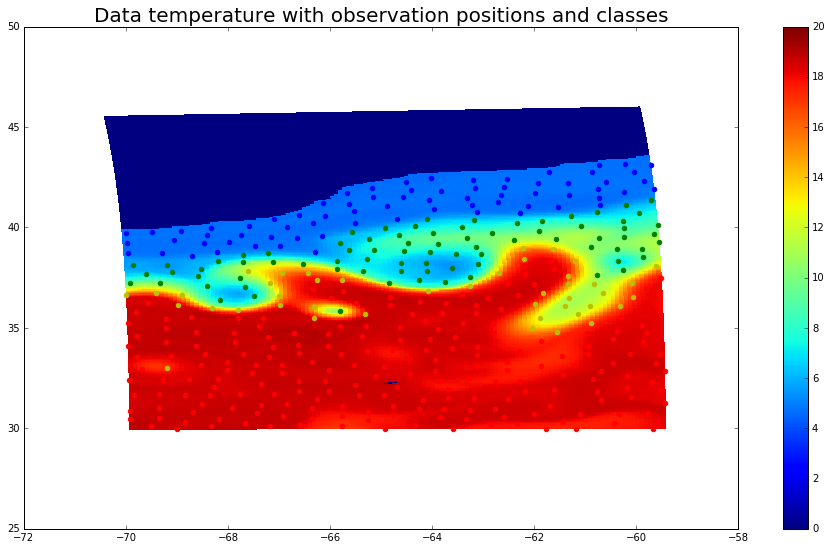

In [17]:
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (16.0, 9.0)

fig, ax = subplots()
p = ax.pcolor(long , lat, temp, cmap=cm.jet, vmin=0, vmax=20)

ind_classes = [] #Array to store indices of observations grouped by class
for k in range(1,5):
    ind = np.where(class_obs == k)
    ind_classes.append(ind)
    scatter(obs_lon[ind], obs_lat[ind], color=colors[k-1])
title('Data temperature with observation positions and classes',fontsize=20)    
cb = fig.colorbar(p)

Les parties bleu foncé correspondent à un des données manquantes. Les points représentent les observations, leur couleur dépend de leur classe 
-  bleue : classe froide
-  verte :  classe semi-froide
-  jaune : classe semi-chaude
-  rouge : classe chaude

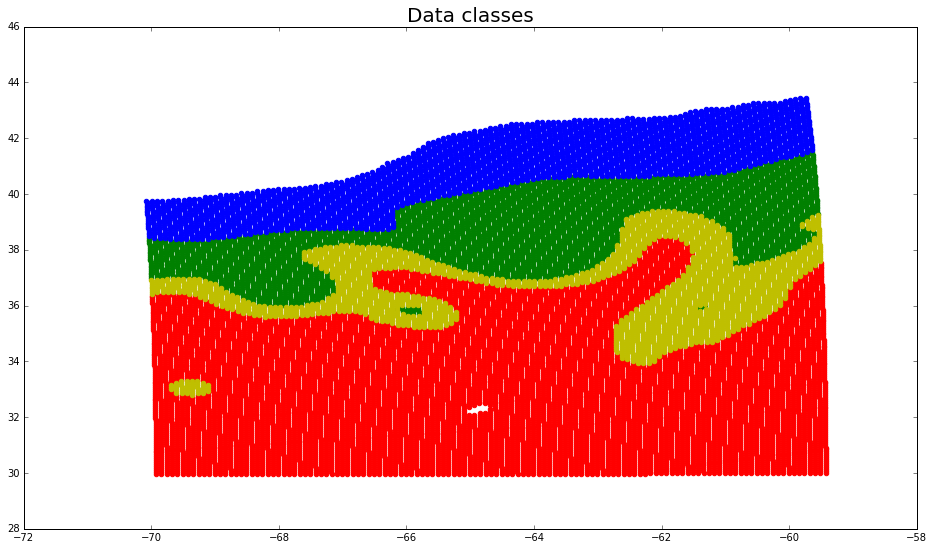

In [18]:
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
title('Data classes',fontsize=20)  

for k in range(1,5):
    ind = np.where(lab == k)
    scatter(long[ind[0],ind[1]], lat[ind[0],ind[1]], color=colors[k-1])

In [19]:
from math import *

#Geodesic distance in km
def dist_geo(long1, lat1, long2, lat2):
    try:
        value= sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360)
        return acos(min(1,value))*6378
    except ValueError:
        print(long1, lat1, long2, lat2,sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360))

#Geodesic distance for vectors
vdist_geo = np.vectorize(dist_geo, excluded=['long1', 'lat1'])

#Returns the distances and indices of k-nearest neighbors from the point (long,lat)
def get_knearest(long, lat, points, indices, k):
    distances = vdist_geo(long, lat, points[:,0], points[:,1])
    s_distances, s_neigh = (np.array(t) for t in zip(*sorted(zip(distances, indices))))
    return s_distances[:k], s_neigh[:k]

#Compute alpha weight from i-th point in distances
def alpha(distances, i, coeff):
    return exp(-distances[i]/coeff)/sum(np.exp(-np.array(distances)/coeff))

#Compute alphas weights for all points in distances
def valpha(distances, coeff):
    l = len(distances)
    alphas = np.zeros((l,))
    for i in range(l):
        alphas[i] = alpha(distances, i, coeff)
    return alphas


In [20]:
#Sorts observations by class
grouped_by_class = [[],[],[],[]]
for l in range(len(obs_lon)):
    c = class_obs[l] - 1
    grouped_by_class[c].append(np.concatenate(([obs_lon[l]], [obs_lat[l]], [obs_ilon[l]], [obs_ilat[l]], [l])))
for t in range(4):
    grouped_by_class[t] = np.array(grouped_by_class[t])


3 types d'interpolation de la température sont considérées:
-  La 1ère méthode est simplement une moyenne pondérée des temperatures des observations voisines. Plus une observation est proche du point à interpoler, plus son poids est fort.
-  La 2nde méthode interpole d'abord les posteriors du point de la même façon que la 1ere méthode interpole la température. Puis la température est estimée comme une moyenne  des moyenne des classes, pondérée par les postériors du point.
-  La 3ème méthode est une variante de la seconde. Au lieu d'utiliser les moyennes globales des classes, pour chaque point, des moyennes locales des classes sont calculées. Pour chaque classe, la moyenn locale est calculée comme une moyenne des températures de toutes les observations appartenant à cette classe, pondérée par les distances des observations au point.

<h3><center>
Interpolation basique:
$$\hat{T} = \sum\limits_{i \in V} \alpha_iT_i$$
Interpolation utilisant les classes de moyenne fixe:
$$\hat{\pi}^{(k)} = \sum\limits_{i \in V} \alpha_i\pi_i^{(k)}$$
$$\hat{T} = \sum\limits_{k=1}^4 \hat{\pi}^{(k)}\mu^{(k)}$$
Interpolation utilisant les classes de moyenne variable:
$$\mu_{loc}^{(k)} = \sum\limits_{i \in C_k} \alpha_{i}T_i$$
$$\hat{T} = \sum\limits_{k=1}^4 \hat{\pi}^{(k)}\mu_{loc}^{(k)}$$
</center></h3>

In [21]:
import copy
warnings.filterwarnings('ignore')
k = 4 #Number of neighbors to consider
coeff = 50 #Coefficient to compute alpha weights for basic temperature estimation and posteriors estimation
coeff2 = 400 #Coefficient to compute alpha weights for local means

bad_temp = np.zeros((127,254)) #Basic estimation of temperature
good_temp = np.zeros((127,254)) #Estimation of temperature using fixed class means
very_good_temp = np.zeros((127,254)) #Estimation of temperature using local class means
est_post = np.zeros((4,127,254)) #Estimation of posteriors
est_lab = np.zeros((127,254)) #Class estimation
#Fixed class means
gaus_mean = np.array([7.70938140771444, 18.5364702094555, 15.4116575244064, 4.702268415742165])

for i in range(127):
    for j in range(254):
        if np.isnan(lab[i,j]) == False:
            lon = long[i,j]
            lati = lat[i,j]
            distances, knearest = get_knearest(lon, lati, np.column_stack((obs_lon, obs_lat)),\
                                               np.column_stack((obs_ilon, obs_ilat)), k)
            
            alphas = valpha(distances, coeff)
            bad_temp[i,j] = sum(alphas*temp[knearest[:,0],knearest[:,1]])
            est_post[:,i,j] = alphas.dot(np.transpose(posteriors[:,knearest[:,0],knearest[:,1]]))
            est_lab[i,j] = np.argmax(est_post[:,i,j]) + 1
            good_temp[i,j] = sum(est_post[:,i,j]*gaus_mean)      
 
            loc_means = copy.copy(gaus_mean)
            for t in range(4):
                if grouped_by_class[t] != []:
                    coord_lon = grouped_by_class[t][:,0]
                    coord_lat = grouped_by_class[t][:,1]
                    ind_lon = grouped_by_class[t][:,2].astype(int)
                    ind_lat = grouped_by_class[t][:,3].astype(int)
                    
                    distances = vdist_geo(lon, lati, coord_lon, coord_lat)
                    alphas = valpha(distances, coeff2)
                    loc_means[t] = sum(alphas*temp[ind_lon, ind_lat])
                    
            very_good_temp[i,j] = sum(est_post[:,i,j]*loc_means)

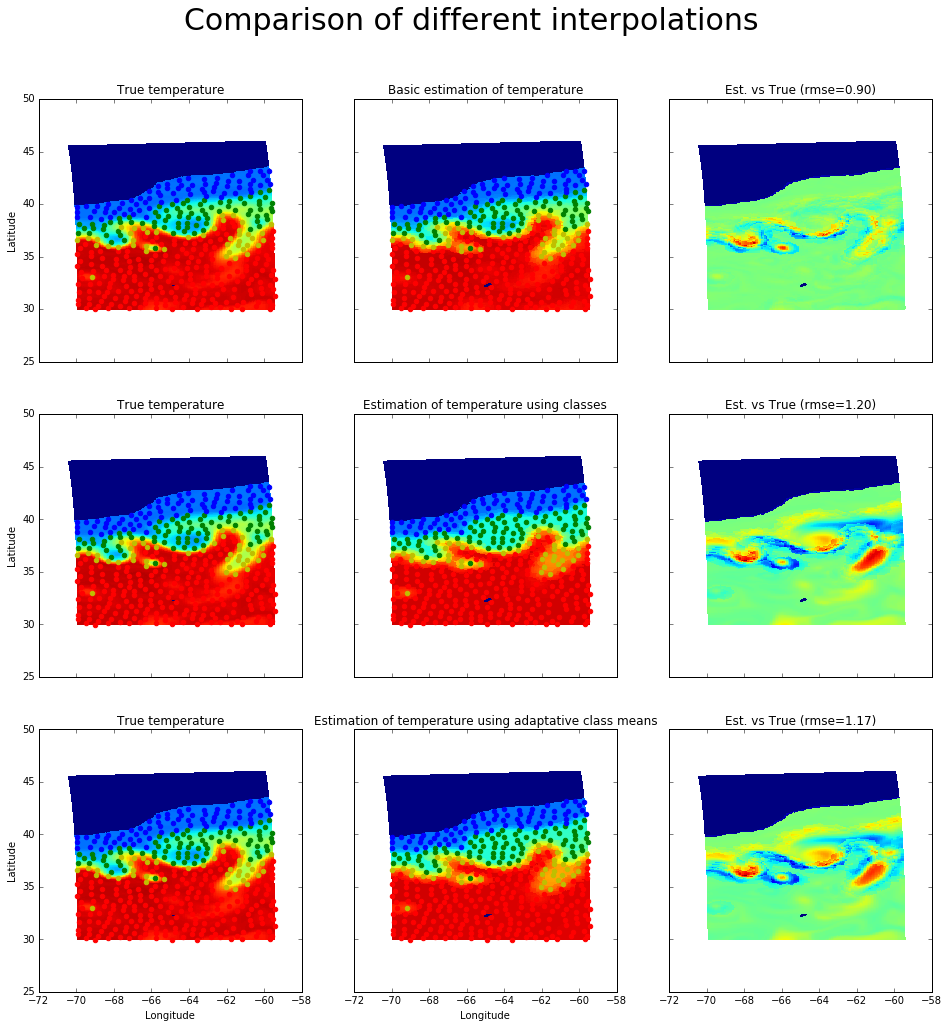

In [22]:
pylab.rcParams['figure.figsize'] = (16,16)
warnings.filterwarnings('ignore')

titles = ['Basic estimation of temperature', 'Estimation of temperature using classes',\
         'Estimation of temperature using adaptative class means']
all_temp = [bad_temp, good_temp, very_good_temp]

f, axarr = plt.subplots(3, 3, sharex='col', sharey='row')
for k in range(3):
    p = axarr[k,0].pcolor(long, lat, temp, cmap=cm.jet, vmin=0, vmax=20)
    axarr[k,0].set_title('True temperature')
    axarr[k,0].set_ylabel('Latitude')
    p = axarr[k,1].pcolor(long, lat, all_temp[k], cmap=cm.jet, vmin=0, vmax=20)
    axarr[k,1].set_title("%s"%(titles[k]))
    p = axarr[k,2].pcolor(long, lat, all_temp[k]-temp, cmap=cm.jet, vmin=-5, vmax=5)
    rms = np.sqrt(np.nanmean(np.array(all_temp[k]-temp)**2))
    axarr[k,2].set_title("Est. vs True (rmse=%0.2f)"%(rms))

for k in range(1,5):
    ind = np.where(class_obs == k)
    for i in range(3):
        for j in range(2):
            p = axarr[i,j].scatter(obs_lon[ind], obs_lat[ind], color=colors[k-1])
axarr[2,0].set_xlabel('Longitude')
axarr[2,1].set_xlabel('Longitude')
f.suptitle('Comparison of different interpolations',fontsize=30)

Si on regarde la bosse jaune à l'Est qui pointe vers le Sud.

Dans le cas de l'interpolation basique la forme de cette bosse n'est pas respectée car au bout de celle-ci, les voisins majoritaires sont ceux de la classe chaude et donc la température estimée est très proche de celle de la classe chaude.

Dans le cas de la seconde interpolation, la forme de la bosse est mieux conservée mais la température par contre est mal estimée. En effet, les trois points jaunes sont classifiés comme classe semi-chaude mais la moyenne globale de cette classe est plus chaude que leur température. D'où une bosse de couleur orange au lieu de jaune/vert.

La troisième méthode permet de corriger cet écart de température. La moyenne locale de cette classe est plus faible que la moyenne globale. Ainsi, on conserve à peu près la forme de la bosse et la température estimée est plus proche de la réalité.

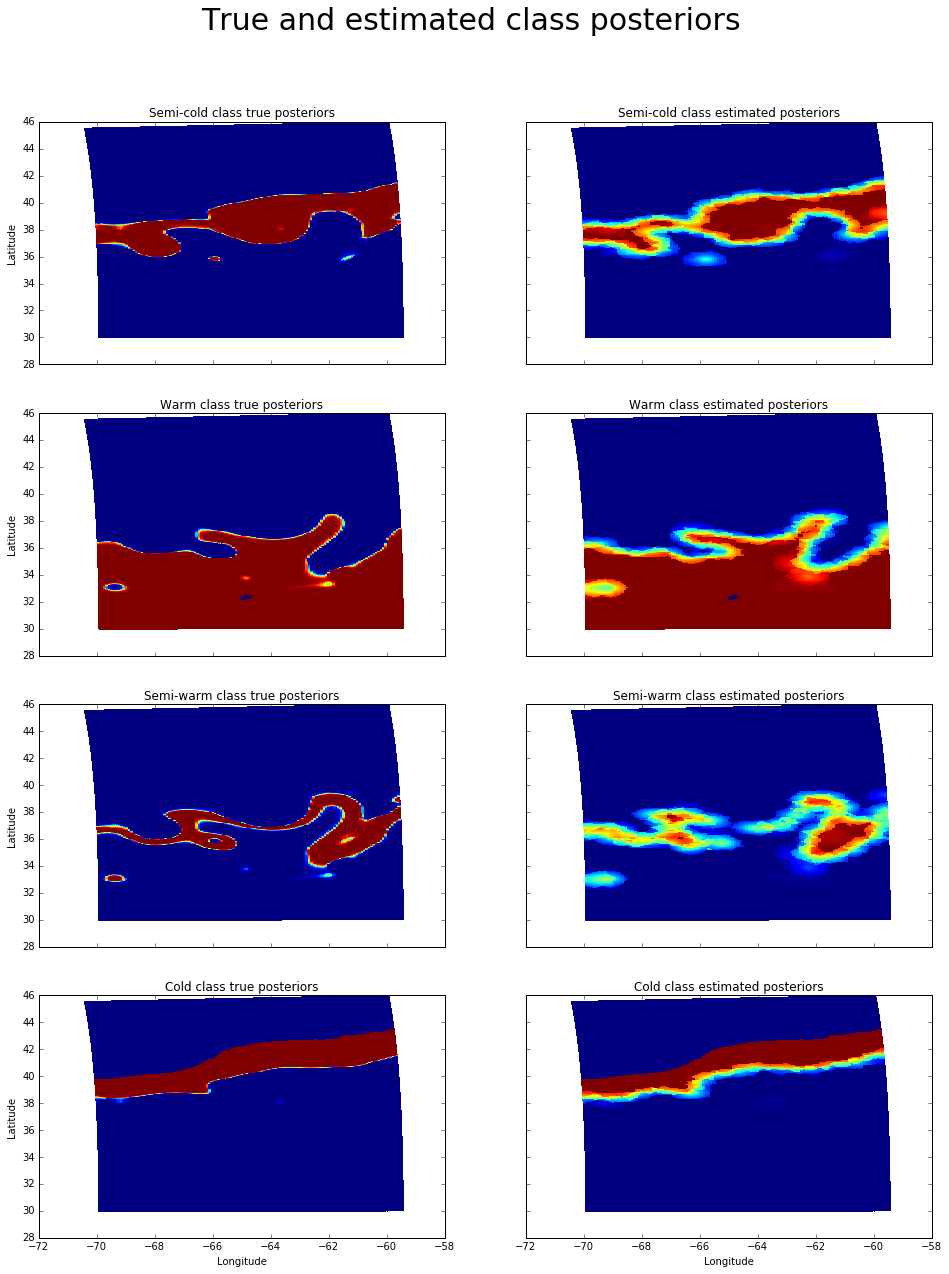

In [23]:
pylab.rcParams['figure.figsize'] = (16.0, 20)
warnings.filterwarnings('ignore')

left_titles = ['Semi-cold class true posteriors','Warm class true posteriors', 'Semi-warm class true posteriors', \
       'Cold class true posteriors']
right_titles = ['Semi-cold class estimated posteriors','Warm class estimated posteriors', \
              'Semi-warm class estimated posteriors', 'Cold class estimated posteriors']

f, axarr = plt.subplots(4, 2, sharex='col', sharey='row')
for k in range(4):
    p = axarr[k,0].pcolor(long, lat, posteriors[k,:,:], cmap=cm.jet, vmin=0, vmax=1)
    axarr[k,0].set_ylabel('Latitude')
    axarr[k,0].set_title(left_titles[k])
    axarr[k,1].set_title(right_titles[k])
    p = axarr[k,1].pcolor(long, lat, est_post[k,:,:], cmap=cm.jet, vmin=0, vmax=1)
axarr[3,0].set_xlabel('Longitude')
axarr[3,1].set_xlabel('Longitude')
f.suptitle('True and estimated class posteriors', fontsize=30)

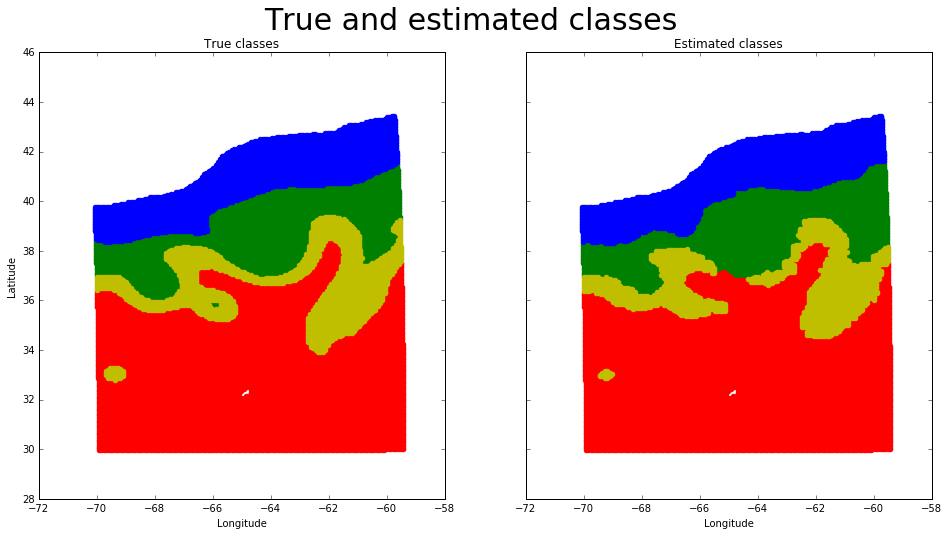

In [24]:
pylab.rcParams['figure.figsize'] = (16, 8)

f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
for k in range(1,5):
    ind1 = np.where(lab == k)
    ind2 = np.where(est_lab == k)
    p = ax1.scatter(long[ind1[0],ind1[1]], lat[ind1[0],ind1[1]], color=colors[k-1])
    ax1.set_title('True classes')
    p = ax2.scatter(long[ind2[0],ind2[1]], lat[ind2[0],ind2[1]], color=colors[k-1])
    ax2.set_title('Estimated classes')
    ax1.set_xlabel('Longitude')
    ax2.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    f.suptitle('True and estimated classes', fontsize=30)